# Captum lib (XAI)

In [1]:
import numpy as np
# import torch
import torch.nn as nn
# from torchvision import models
import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%run utils.py
%run utilsT.py
%run utilsTesting.py

In [4]:
%run models/__init__.py

In [6]:
DEVICE = get_torch_device(gpu=False)

In [7]:
chosen_diseases = ALL_DISEASES[:]

## Load model

In [7]:
# model = init_empty_model("v3", chosen_diseases).to(DEVICE)

In [8]:
run_name = "1121_180210_resnet_v3_wd0.5_Cardiomegaly"
model, model_name, optimizer, opt_name, loss_name, loss_params, chosen_diseases = load_model(
    BASE_DIR, run_name, device=DEVICE, force_multiple_gpu=False)
model = model.to(DEVICE)

In [9]:
_ = model.eval()

In [10]:
def get_forward_wrapper(model):
    def fw_wrapper(*args):
        output, embeddings, activations = model(*args)
        return output
    
    return fw_wrapper

In [11]:
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
        
    def forward(self, input_img):
        output, _, _ = self.model(input_img)
        return output

## Load data

In [12]:
%%time
dataset, dataloader = prepare_data(DATASET_DIR, "test", ALL_DISEASES, 1, max_images=None)
n_images, n_diseases = dataset.size()
n_images, n_diseases

CPU times: user 32.7 s, sys: 109 ms, total: 32.8 s
Wall time: 33.9 s


(25596, 14)

In [13]:
def get_cms_names(run_name, disease_name):
    fname = CMS_DIR + "/" + run_name + "_test_names"

    TP, FP, TN, FN, cm = load_cms_names(fname, disease_name)
    print(cm)
    return TP, FP, TN, FN, cm

In [14]:
TP, FP, TN, FN, cm = get_cms_names(run_name, "Cardiomegaly")

[[24048   479]
 [  852   217]]


## Plot fns

In [15]:
def plot_fn(image_name, disease_name=None):
    # FIXME: this function is copied from calculate_plot_activations() (in Testing.ipynb)

    image, gt, prediction, bboxes, activation = gen_image_with_bbox(model,
                                                                    dataset,
                                                                    image_name,
                                                                    chosen_diseases,
                                                                    DEVICE,
                                                                   )
    # print(gt)
    plt.figure(figsize=(22, 8))
    
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 3, 1)
    plot_image_with_bbox(image, image_name, bboxes)

    plt.subplot(1, 3, 2)
    plot_activation(activation, prediction, gt, chosen_diseases, disease_name=disease_name)
    
    # FIXME: this is copied from plot_activation()
    if disease_name is None:
        disease_name = chosen_diseases[0]

    disease_index = chosen_diseases.index(disease_name)

    pred = prediction[disease_index]
    
    print("Ground truth: {} {}".format(disease_name, gt[disease_index]))
    print("Prediction: {:.4f}".format(pred))

In [14]:
image, labels, image_name, bboxes, bbox_valid = dataset.get_by_name(TP[0])
images = image.view(1, *image.size()).to(DEVICE)
output, _, _ = model(images)

In [15]:
output.size()

torch.Size([1, 1])

## Integrated gradients

In [16]:
from captum.attr import IntegratedGradients

In [17]:
# n_samples = 1
# image_channels = 3
# image_height = 512
# image_width = 512

# sample_input = torch.rand(n_samples, image_channels, image_height, image_width).to(DEVICE)

In [18]:
ig = IntegratedGradients(get_forward_wrapper(model))

In [20]:
def plot_ig(image_name, label, n_steps=5):
    image, labels, image_name, bboxes, bbox_valid = dataset.get_by_name(image_name)
    
    images = image.view(1, *image.size()).to(DEVICE)

    target = torch.Tensor([[label], [label]]).to(DEVICE)
    
#     print(labels)
    # print(images.size())
#     print(target.size())
    
    attributions = ig.attribute(images, n_steps=n_steps)
    attr_hwc = np.transpose(attributions.cpu()[0], [1, 2, 0])
    attr_hwc = image_to_range(attr_hwc, 0, 1)

    plt.subplot(1, 3, 3)
    plt.title("Integrated gradients")
    plt.imshow(attr_hwc) #, cmap="Reds")
    # plt.colorbar()
    
    return attr_hwc

Ground truth: Cardiomegaly 1
Prediction: 0.9892


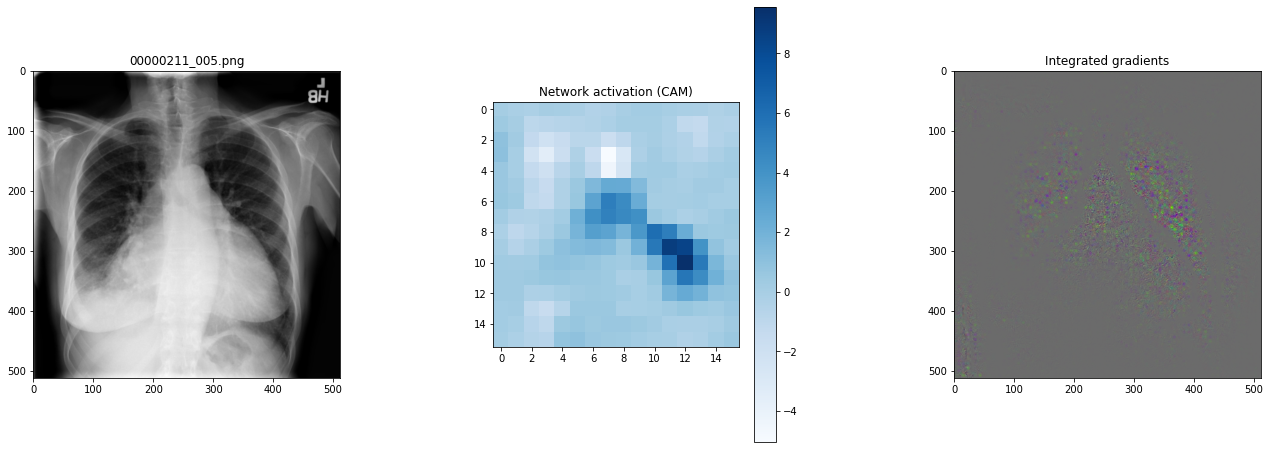

In [21]:
image_name = TP[3]

plot_fn(image_name)
attr = plot_ig(image_name, 0, n_steps=2)

In [26]:
r = attr[:, :, 0]
g = attr[:, :, 1]
b = attr[:, :, 2]

(array([8.00000e+00, 2.20000e+01, 1.07000e+02, 5.32000e+02, 8.78700e+03,
        2.49106e+05, 3.13600e+03, 3.74000e+02, 5.90000e+01, 1.30000e+01]),
 array([0.02260736, 0.09702327, 0.17143919, 0.2458551 , 0.32027102,
        0.39468693, 0.46910284, 0.54351876, 0.61793467, 0.69235059,
        0.7667665 ]),
 <a list of 10 Patch objects>)

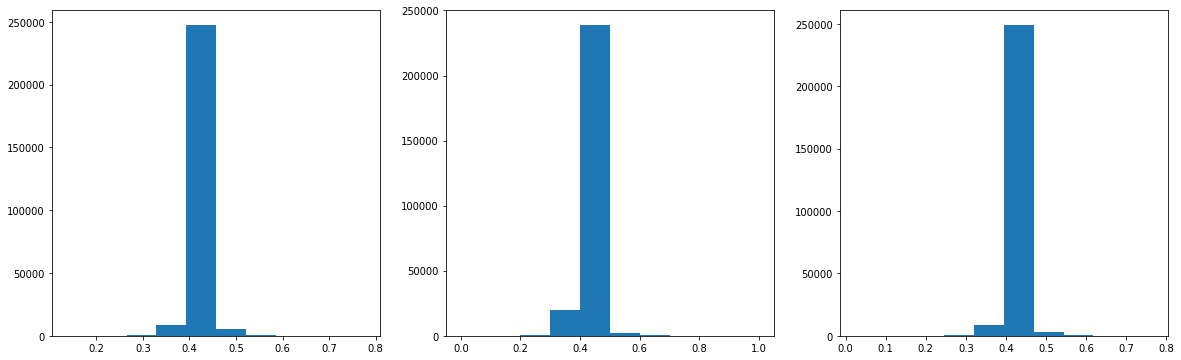

In [29]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.hist(r.flatten())

plt.subplot(1, 3, 2)
plt.hist(g.flatten())

plt.subplot(1, 3, 3)
plt.hist(b.flatten())

In [30]:
sums = r * 10 + g * 100 +  b * 1000

(array([8.00000e+00, 2.10000e+01, 1.21000e+02, 6.92000e+02, 1.23480e+04,
        2.45338e+05, 3.17400e+03, 3.75000e+02, 5.40000e+01, 1.30000e+01]),
 array([104.82072877, 173.17096787, 241.52120697, 309.87144606,
        378.22168516, 446.57192426, 514.92216336, 583.27240246,
        651.62264156, 719.97288066, 788.32311976]),
 <a list of 10 Patch objects>)

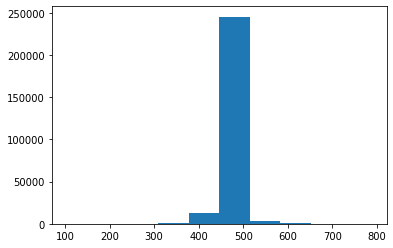

In [35]:
plt.hist(sums.flatten())

In [32]:
std_devs = np.std(attr, axis=2)
std_devs.shape

(512, 512)

(array([1.97704e+05, 3.07070e+04, 1.33500e+04, 7.03000e+03, 4.21400e+03,
        2.62700e+03, 1.79100e+03, 1.12400e+03, 8.69000e+02, 6.18000e+02,
        4.84000e+02, 3.50000e+02, 2.22000e+02, 2.01000e+02, 1.46000e+02,
        1.32000e+02, 8.90000e+01, 8.80000e+01, 6.30000e+01, 5.50000e+01,
        4.30000e+01, 4.50000e+01, 3.40000e+01, 2.70000e+01, 2.70000e+01,
        2.30000e+01, 2.00000e+01, 1.40000e+01, 1.10000e+01, 9.00000e+00,
        2.00000e+00, 6.00000e+00, 4.00000e+00, 1.00000e+00, 4.00000e+00,
        2.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([4.88556900e-08, 7.76846717e-03, 1.55368855e-02, 2.33053038e-02,
        3.10737221e-02, 3.88421404e-02, 4.66105587e-02, 5.43789770e-02,
        6.21473954e-02, 6.99158137e-02, 7.76842320e-02, 8.54526503e-02,
        9.32210686e-02, 1.00989487e-01, 1.08757905e-

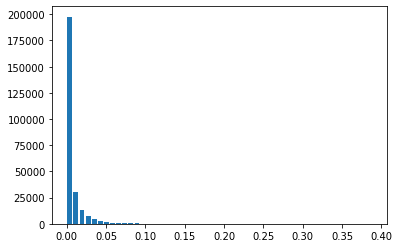

In [38]:
plt.hist(std_devs.flatten(), bins=50, rwidth=0.8)

Ground truth: Cardiomegaly 1
Prediction: 0.9282


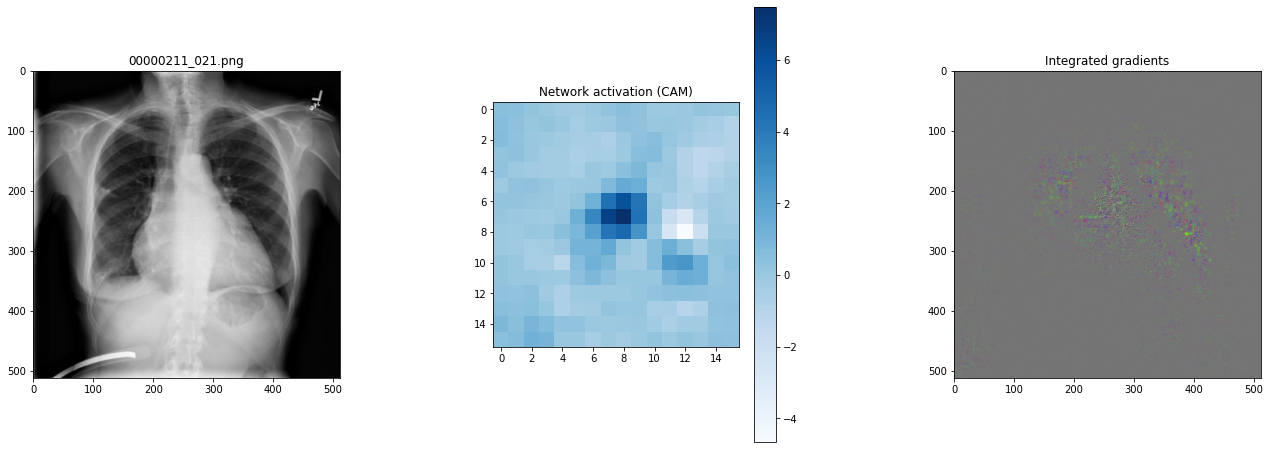

In [61]:
image_name = TP[10]

plot_fn(image_name)
plot_ig(image_name, 0, n_steps=2)

Ground truth: Cardiomegaly 1
Prediction: 0.8901


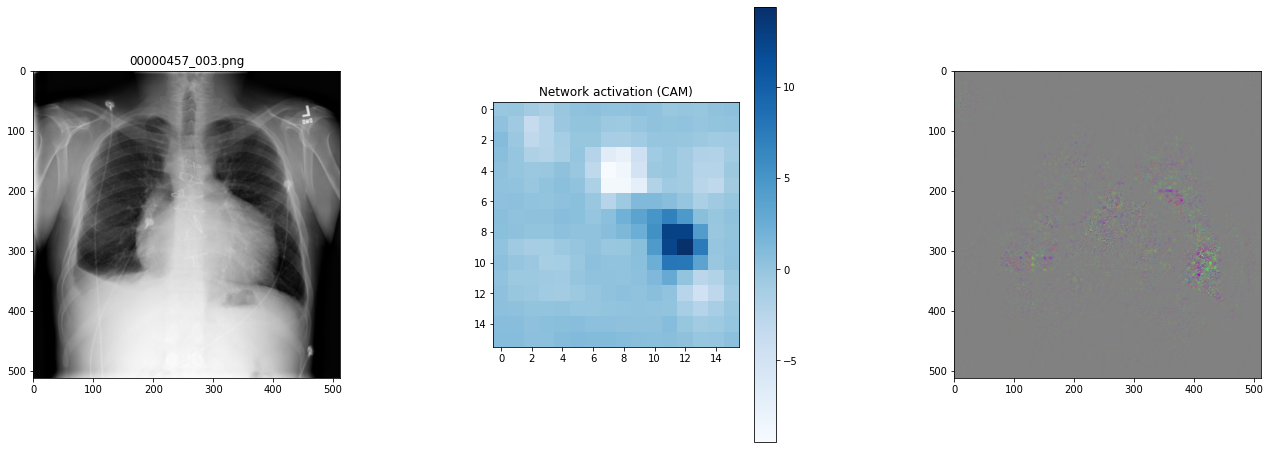

In [41]:
image_name = TP[13]

plot_fn(image_name)
plot_ig(image_name, 0, n_steps=2)

Ground truth: Cardiomegaly 1
Prediction: 0.9984


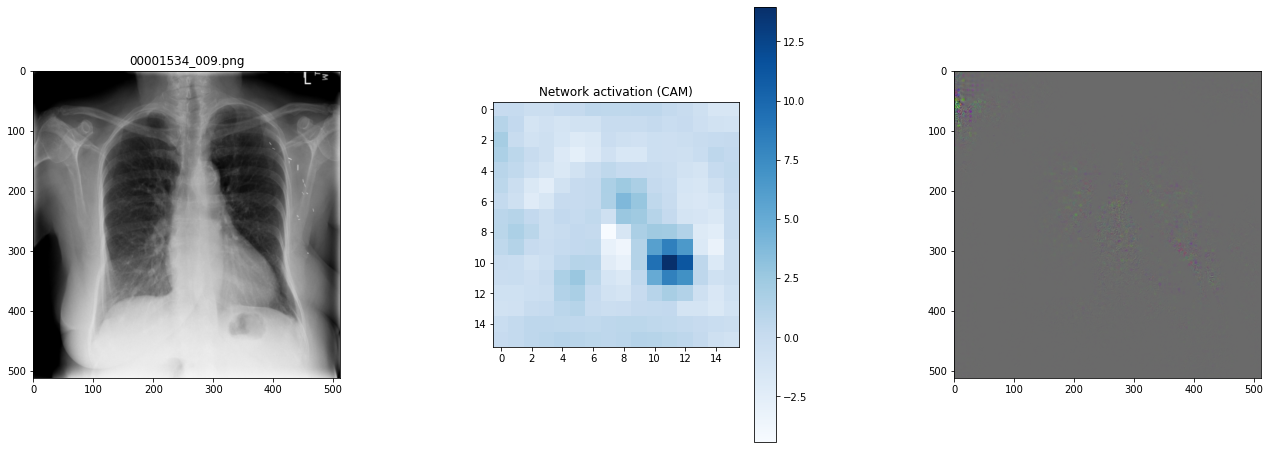

In [50]:
image_name = TP[30]

plot_fn(image_name)
plot_ig(image_name, 0, n_steps=2)

Ground truth: Cardiomegaly 0
Prediction: 0.0023


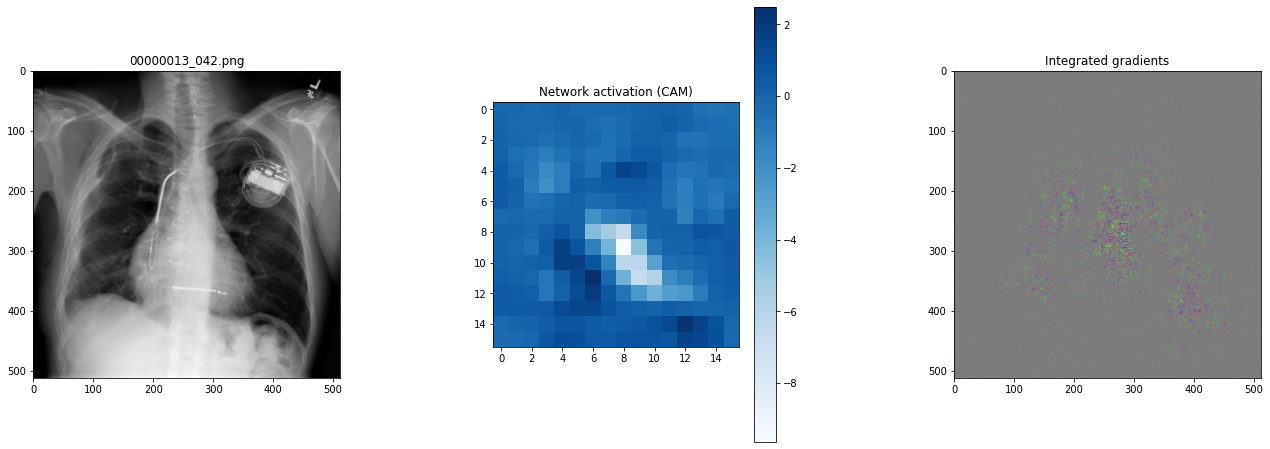

In [75]:
image_name = TN[42]

plot_fn(image_name)
plot_ig(image_name, 0, n_steps=2)

Ground truth: Cardiomegaly 0
Prediction: 0.6455


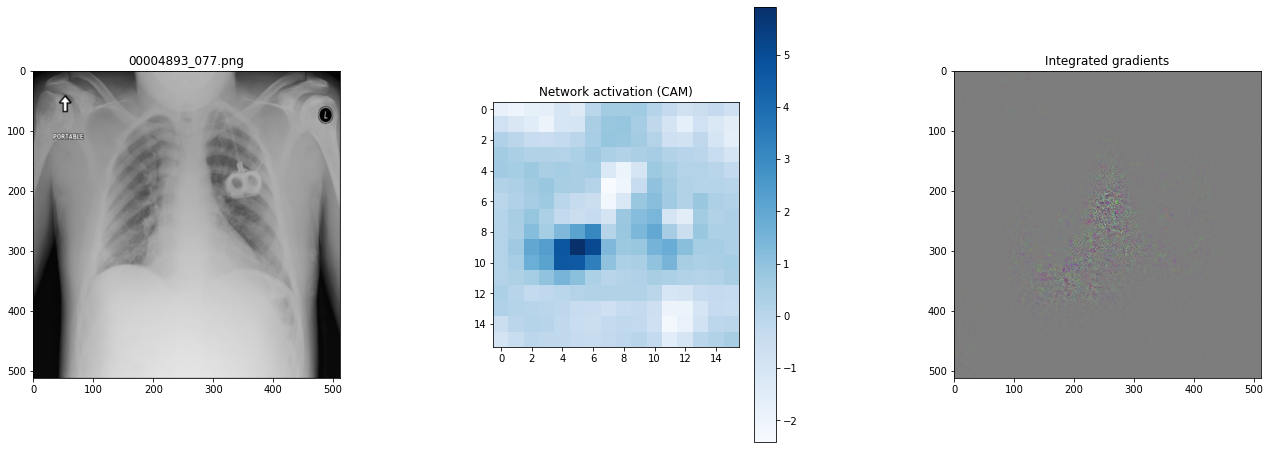

In [162]:
image_name = FP[107]

plot_fn(image_name)
plot_ig(image_name, 0, n_steps=2)

In [86]:
for i in TP+FN:
    if "0211_" in i:
        print(i)

00000211_002.png
00000211_004.png
00000211_005.png
00000211_006.png
00000211_007.png
00000211_009.png
00000211_011.png
00000211_013.png
00000211_014.png
00000211_021.png
00000211_034.png
00000211_035.png
00000211_000.png
00000211_001.png
00000211_008.png
00000211_010.png
00000211_016.png
00000211_018.png
00000211_019.png
00000211_022.png
00000211_024.png
00000211_037.png
00000211_038.png
00000211_039.png
00000211_041.png
00000211_043.png


In [87]:
for i in TN+FP:
    if "0211_" in i:
        print(i)

00000211_003.png
00000211_015.png
00000211_017.png
00000211_020.png
00000211_023.png
00000211_027.png
00000211_036.png
00000211_040.png
00000211_042.png
00000211_012.png
00000211_025.png
00000211_026.png
00000211_028.png
00000211_029.png
00000211_030.png
00000211_031.png
00000211_032.png
00000211_033.png


## DeepLIFT

In [16]:
from captum.attr import DeepLift

In [17]:
dl = DeepLift(model) # ModelWrapper(model))

In [24]:
def plot_dl(image_name):
    image, labels, image_name, bboxes, bbox_valid = dataset.get_by_name(image_name)
    
    images = image.view(1, *image.size()).to(DEVICE)

    attributions = dl.attribute(images)
    attr_hwc = np.transpose(attributions.detach().cpu()[0], [1, 2, 0])
    attr_hwc = image_to_range(attr_hwc, 0, 1)

    plt.subplot(1, 3, 3)
    plt.title("Deep Lift")
    plt.imshow(attr_hwc)

Ground truth: Cardiomegaly 1
Prediction: 0.0000


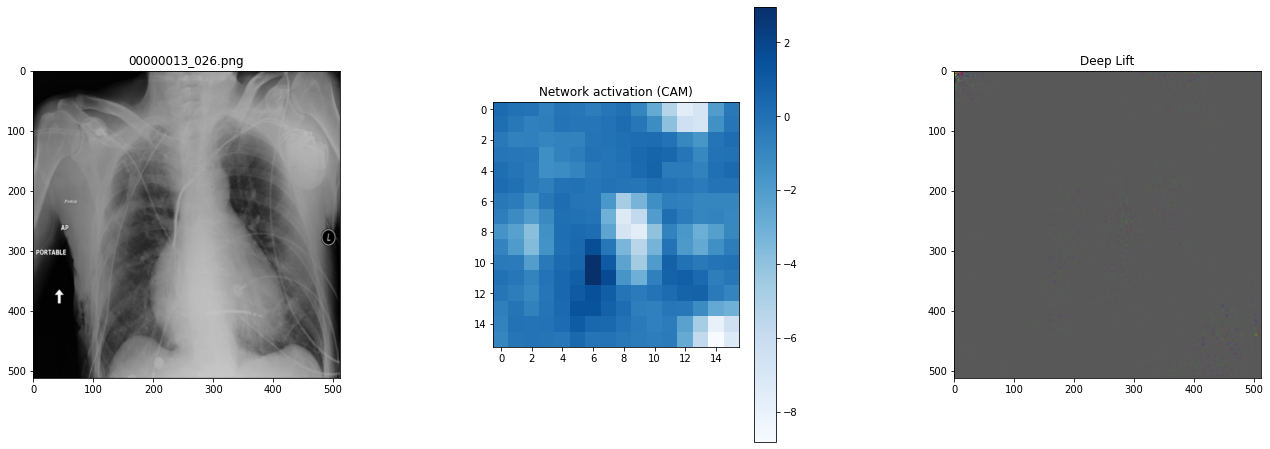

In [54]:
image_name = FN[1]

plot_fn(image_name)
plot_dl(image_name)

## Grad-CAM

In [55]:
from captum.attr import LayerGradCam

In [56]:
grad_cam = LayerGradCam(model, model.model_ft.layer4)

In [75]:
def plot_grad_cam(image_name):
    image, labels, image_name, bboxes, bbox_valid = dataset.get_by_name(image_name)
    
    images = image.view(1, *image.size()).to(DEVICE)
    
    attributions = grad_cam.attribute(images)
    attributions = attributions.detach().cpu()[0][0]

    plt.subplot(1, 3, 3)
    plt.title("Grad CAM")
    plt.imshow(attributions, cmap="Reds")
    plt.colorbar()

Ground truth: Cardiomegaly 1
Prediction: 1.0000


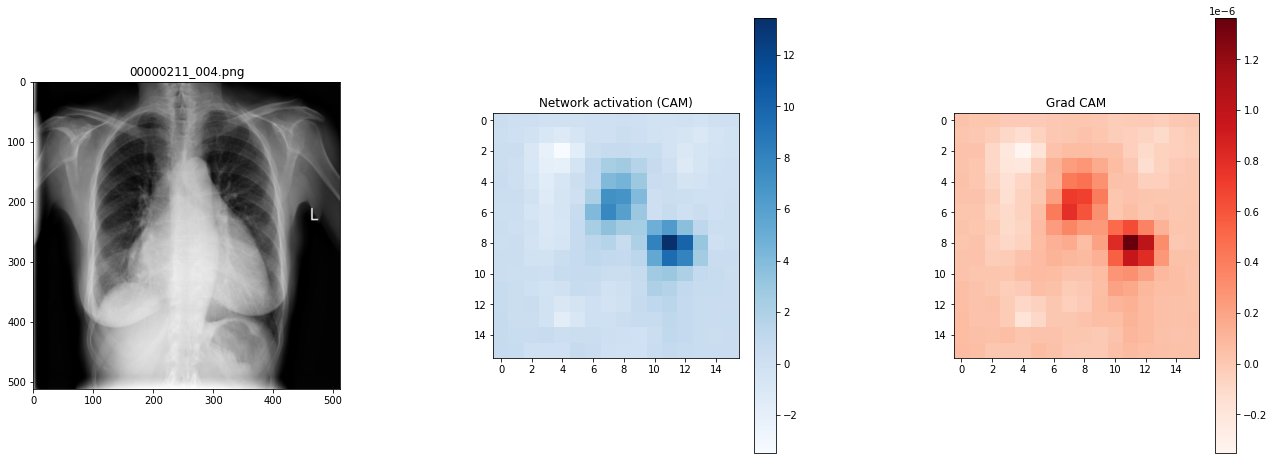

In [78]:
image_name = TP[2]

plot_fn(image_name)
plot_grad_cam(image_name)